# Explorer correlation function
we calculate the correlation function with the following expression
$$
	\mathcal{G}(\rho) = \sum_{i=2}^{n_v} \left(\frac{\lambda_i}{\lambda_1}\right)^\rho  \langle t_1 |\hat{\sigma}_z|t_j\rangle \langle t_i |\hat{\sigma}_z|t_1\rangle.
$$

In [2]:
%pylab inline

import h5py
import numpy as np
from isingchat.io import read_ising_config
from isingchat import ising
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re


Populating the interactive namespace from numpy and matplotlib


In [3]:
from isingchat.ising import _csr_log_transfer_matrix_parts_fast
from isingchat.ising import z_projection_gen
from isingchat.ising import _csr_finite_log_transfer_matrix_parts_fast,csr_matrix,eigvals,_centrosym_log_transfer_matrix_parts_fast
from scipy import linalg
from scipy.sparse.linalg import eigs as sparse_eigs
import scipy

def correlation_function_TL(
    r: int,
    temp: float,
    mag_field: float,
    interactions: np.ndarray,
    num_tm_eigvals: int = None
):
    num_neighbors = len(interactions)
    nnz_elems, nnz_rows, nnz_cols = _csr_log_transfer_matrix_parts_fast(
        temp, mag_field, interactions, num_neighbors
    )

    # Normalize nonzero matrix elements.
    max_w_log_elem = np.max(nnz_elems)
    nnz_elems -= max_w_log_elem
    norm_nnz_elems = np.exp(nnz_elems)
    # Construct the sparse matrix.
    num_rows = 2 ** num_neighbors
    w_shape = (num_rows, num_rows)
    w_matrix = csr_matrix(
        (norm_nnz_elems, (nnz_rows, nnz_cols)), shape=w_shape
    )
    # Evaluate the largest eigenvalue, since it defines the free energy in
    # the thermodynamic limit.
    # noinspection PyTypeChecker
    if num_tm_eigvals is None:
        num_eigvals = min(num_neighbors ** 2, num_rows - 2)
    else:
        num_eigvals = min(num_tm_eigvals, num_rows - 2)
    # For three or two interactions we take all eigenvalues
    if len(interactions) <= 3:
        w_matrix_dense = w_matrix.todense()
        # w_all_norm_eigvals, w_all_norm_eigvect = scipy.linalg.eig(w_matrix_dense)
        # w_norm_eigvals = w_all_norm_eigvals[0]
        w_norm_eigvals, w_norm_eigvect = scipy.linalg.eig(w_matrix_dense)
    else:
        w_norm_eigvals, w_norm_eigvect = sparse_eigs(
            w_matrix, k=num_eigvals, which="LM", return_eigenvectors=False
        )
    eigvals_norms: np.ndarray = np.abs(w_norm_eigvals)
    max_eigval_norm_idx = eigvals_norms.argmax()
    max_eigval_norm = eigvals_norms[max_eigval_norm_idx]
    max_eigvect_norm = w_norm_eigvect[max_eigval_norm_idx]
    reduced_eigvals = (w_norm_eigvals / max_eigval_norm)**r
    sigma_z = z_projection_gen(num_neighbors-1)# matrix extension
    corr_function = 0
    for ind_eig in range(len(reduced_eigvals)):
        if ind_eig == max_eigval_norm_idx:
            pass
        else:
            corr_function += (reduced_eigvals[ind_eig])*(
                np.abs(max_eigvect_norm.dot(sigma_z.dot(w_norm_eigvect[ind_eig])))**2
            )
        
    return corr_function

def correlation_lenght_TL(
    r: int,
    temp: float,
    mag_field: float,
    interactions: np.ndarray,
    num_tm_eigvals: int = None
):
    return -(1/r)*math.log(correlation_function_TL(r,temp,mag_field,interactions,num_tm_eigvals))


def correlation_lenght_limit(
    temp: float,
    mag_field: float,
    interactions: np.ndarray
):
    num_neighbors = len(interactions)
    nnz_elems, nnz_rows, nnz_cols = _csr_log_transfer_matrix_parts_fast(
        temp, mag_field, interactions, num_neighbors
    )

    # Normalize nonzero matrix elements.
    max_w_log_elem = np.max(nnz_elems)
    nnz_elems -= max_w_log_elem
    norm_nnz_elems = np.exp(nnz_elems)
    # Construct the sparse matrix.
    num_rows = 2 ** num_neighbors
    w_shape = (num_rows, num_rows)
    w_matrix = csr_matrix(
        (norm_nnz_elems, (nnz_rows, nnz_cols)), shape=w_shape
    )
    # For three or two interactions we take all eigenvalues
    if len(interactions) <= 2:
        w_matrix_dense = w_matrix.todense()
        # w_all_norm_eigvals, w_all_norm_eigvect = scipy.linalg.eig(w_matrix_dense)
        # w_norm_eigvals = w_all_norm_eigvals[0]
        w_norm_eigvals, w_norm_eigvect = scipy.linalg.eig(w_matrix_dense)        
    else:
        w_norm_eigvals, w_norm_eigvect = sparse_eigs(
            w_matrix, k=2, which="LM"
        )
        print(w_norm_eigvals)
    eigvals_norms: np.ndarray = np.abs(w_norm_eigvals)
    print('before sort eigvals: {}'.format(eigvals_norms))
    eigvals_norms[::-1].sort()
    print('after sort eigvals: {}'.format(eigvals_norms))
#     max_eigval_norm_idx = eigvals_norms.argmax()
#     max_eigval_norm = eigvals_norms[max_eigval_norm_idx]
#     max_eigvect_norm = w_norm_eigvect[max_eigval_norm_idx]
#     reduced_eigvals = (w_norm_eigvals / max_eigval_norm)
        
    return 1/math.log(eigvals_norms[0]/eigvals_norms[1])

In [4]:
temp = 2
mag_field = 0
interactions = np.array([1.0, 0.5]) # p=1
# interactions = np.array([1.0]) # p=1
eigens_TM_TL(temp,mag_field,interactions)

NameError: name 'eigens_TM_TL' is not defined

In [7]:
def eigens_TM_TL(
    temp: float,
    mag_field: float,
    interactions: np.ndarray,
    num_tm_eigvals: int = None
):
    """
        Return max_w_log_elem and eigenvectors of the transfer matrix of the infinite chain
        In case of len(interactions) > 3, the default num eigenvalues returned is min(num_neighbors ** 2, num_rows - 2)
    """
    num_neighbors = len(interactions)
    nnz_elems, nnz_rows, nnz_cols = _csr_log_transfer_matrix_parts_fast(
        temp, mag_field, interactions, num_neighbors
    )

    # Normalize nonzero matrix elements.
    max_w_log_elem = np.max(nnz_elems)
    nnz_elems -= max_w_log_elem
    norm_nnz_elems = np.exp(nnz_elems)
    # Construct the sparse matrix.
    num_rows = 2 ** num_neighbors
    w_shape = (num_rows, num_rows)
    w_matrix = csr_matrix(
        (norm_nnz_elems, (nnz_rows, nnz_cols)), shape=w_shape
    )
    # Check num_tm_eigvals in order to use eigs sparse routine or dense sparse routine
    if num_tm_eigvals is None:
        num_eigvals = min(num_neighbors ** 2, num_rows - 2) # Defaul num_eigvals
    else:
        num_eigvals = num_tm_eigvals
    if num_eigvals > num_rows - 2:
        w_matrix_dense = w_matrix.todense()
        # w_all_norm_eigvals, w_all_norm_eigvect = scipy.linalg.eig(w_matrix_dense)
        # w_norm_eigvals = w_all_norm_eigvals[0]
        w_norm_eigvals, w_norm_eigvect = scipy.linalg.eig(w_matrix_dense)
        if num_eigvals > num_rows:
            print('Warning: The number of eigenvalues can not be greater than num of the rows. We calculate all eigevals')

            return max_w_log_elem, w_norm_eigvals, w_norm_eigvect #return all eigvals
        else:
            return max_w_log_elem, w_norm_eigvals[:num_eigvals], w_norm_eigvect[:,:num_eigvals]
    else:
        w_norm_eigvals, w_norm_eigvect = sparse_eigs(
            w_matrix, k=num_eigvals, which="LM"
        )
        
        return max_w_log_elem, w_norm_eigvals, w_norm_eigvect
    
    
def correlation_function_TL(
    r: int,
    temp: float,
    mag_field: float,
    interactions: np.ndarray,
    num_tm_eigvals: int = None
):
    num_neighbors = len(interactions)
    if num_tm_eigvals is None:
        num_tm_eigvals = 2**num_neighbors # all eigenvalues
        
    _, w_norm_eigvals, w_norm_eigvects = eigens_TM_TL(temp,mag_field,interactions,num_tm_eigvals)
    eigvals_norms: np.ndarray = np.abs(w_norm_eigvals)
    max_eigval_norm_idx = eigvals_norms.argmax()
    max_eigval_norm = eigvals_norms[max_eigval_norm_idx]
#     print('max_eigval_norm_idx : {}'.format(max_eigval_norm_idx))
    max_eigvect_norm = w_norm_eigvects[:,max_eigval_norm_idx]
    reduced_eigvals = (w_norm_eigvals / max_eigval_norm)**r
    sigma_z = z_projection_gen(num_neighbors-1)# matrix extension
    corr_function = 0
#     print('eigenvals: {}'.format(w_norm_eigvals))
#     print('eigenvects: {}'.format(w_norm_eigvects))
#     print('eigenvect: {}'.format(w_norm_eigvects[:,1]))
#     print('eigenvects: {}'.format(w_norm_eigvects))
#     print('max_eigenvect: {}'.format(max_eigvect_norm))
#     print('product: {}'.format(sigma_z.dot(w_norm_eigvects[:,1])))
    for ind_eig in range(len(reduced_eigvals)):
        if ind_eig == max_eigval_norm_idx:
            pass
        else:
            corr_function += (reduced_eigvals[ind_eig])*(
                np.abs(max_eigvect_norm.dot(sigma_z.dot(w_norm_eigvects[:,ind_eig])))**2
            )
        
    return corr_function
    
def correlation_lenght_limit(
    temp: float,
    mag_field: float,
    interactions: np.ndarray
):
    _, w_norm_eigvals, _ = eigens_TM_TL(temp,mag_field,interactions,2)
    eigvals_norms: np.ndarray = np.abs(w_norm_eigvals)
    eigvals_norms[::-1].sort()
        
    return 1/abs(math.log(eigvals_norms[0]/eigvals_norms[1]))

In [8]:
r = 1
temp = 2
mag_field = 0
interactions = np.array([1.0, 0.5]) # p=1
# interactions = np.array([1.0]) # p=1
# max_w_log_elem, w_norm_eigvals, w_norm_eigvect = eigens_TM_TL(temp,mag_field,interactions)
# correlation_lenght_limit(temp,mag_field,interactions)
correlation_function_TL(r,temp,mag_field,interactions)

(0.6141309374829983+0j)

In [9]:
eigens_TM_TL(temp,mag_field,interactions,2)

(0.75,
 array([1.16894424+0.j, 0.89263487+0.j]),
 array([[ 0.68117564+0.j, -0.69628214+0.j],
        [ 0.189736  +0.j,  0.1232525 +0.j],
        [ 0.189736  +0.j, -0.1232525 +0.j],
        [ 0.68117564+0.j,  0.69628214+0.j]]))

### Ploting correlation function

In [10]:
p=1
nv=3
1/np.arange(1,nv+1,1)**p

array([1.        , 0.5       , 0.33333333])

C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, '$G(\\rho)$')

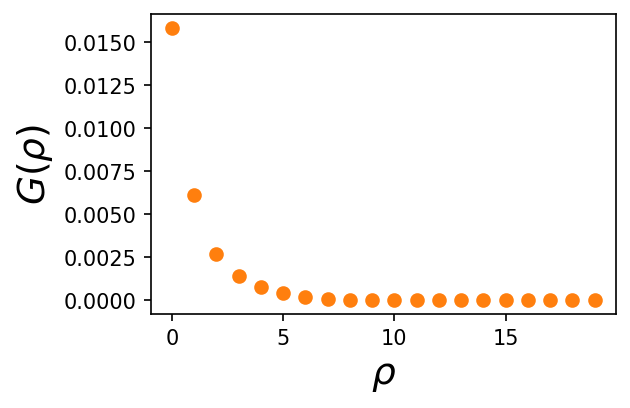

In [11]:
temp = 15 #k_BT/J
mag_field = 0
p=1.1
nv = 5
interactions = 1/np.arange(1,nv+1,1)**p
# interactions = np.array([1.0,0.5,0.33,0.25,0.2]) # p=1 
# interactions = np.array([1.0]) # p=1

# plots
fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
# fig1: Figure = pyplot.figure(figsize=(12*(4/9), 12), dpi=150)
# fig1: Figure = pyplot.figure(figsize=(4, 4*(2/3)), dpi=150)
    
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])
    
x_data = np.arange(0,20,1)
# y_data = [corr_lenght_ising_original_limit_zero_h(x) for x in x_data]
          
# ax.plot(x_data, y_data, marker="o", lw=0,color='C0',label='adjust without nv=1')
# # ax.semilogy(x_data, y_data, marker="o", lw=0,color='C0',label='adjust without nv=1')

y_data = [correlation_function_TL(
    r,
    temp,
    mag_field,
    interactions
) for r in x_data]

ax.plot(x_data, y_data, marker="o", lw=0,color='C1',label='adjust without nv=1')

# labels configurations
ax.xaxis.label.set_size(18)
ax.set_xlabel(r"$\rho$")

ax.yaxis.label.set_size(18)
ax.set_ylabel(r"$G(\rho)$")

# ax.set_ylim(0.9,1.2)
# ax.set_xlim(0, 0.5)

### ploting correlation_lenght_limit as function of temp

C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


Datos nv=9: [2.9537602185469702, 4.0521853315269745, 5.850226155175404, 9.276276670054399, 16.642490797238395, 33.42484471640251, 71.43897624652755, 155.08465653046372, 334.3589559760652, 711.1208869057948, 1491.5545895790485, 3090.867412253735, 6341.974217352923, 12910.919017726423, 26122.992297252058, 52604.252745766964, 105541.25174282756, 211151.02141055017]


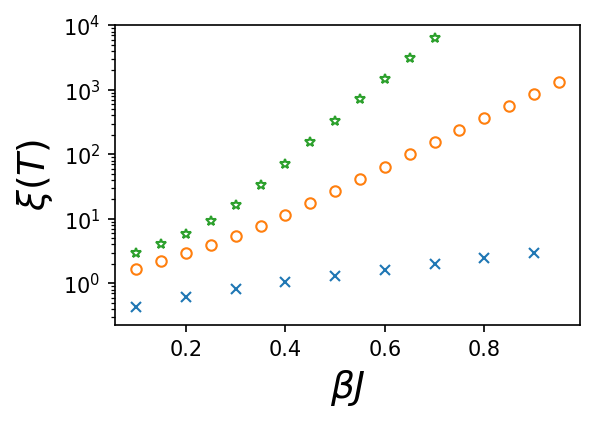

In [30]:
# temp = 2
mag_field = 0
p=1.2
nv = 5
x_min = 0.001
x
x_max = 1
interactions = 1/np.arange(1,nv+1,1)**p
# interactions = np.array([1.0, 0.5,0.33]) # p=1
# interactions = np.array([1.0]) # p=1

# plots
fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
# fig1: Figure = pyplot.figure(figsize=(12*(4/9), 12), dpi=150)
# fig1: Figure = pyplot.figure(figsize=(4, 4*(2/3)), dpi=150)
    
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])
    
x_data = np.arange(0.1,1,0.05)
# y_data = [corr_lenght_ising_original_limit_zero_h(x) for x in x_data]
          
# ax.plot(x_data, y_data, marker="o", lw=0,color='C0',label='adjust without nv=1')
# # ax.semilogy(x_data, y_data, marker="o", lw=0,color='C0',label='adjust without nv=1')

y_data = [correlation_lenght_limit(
    1/temp,
    mag_field,
    interactions
) for temp in x_data]

# y_data_log = [np.log(correlation_lenght_limit(
#     1/temp,
#     mag_field,
#     interactions
# )) for temp in x_data]


# ax.plot(x_data, y_data, marker="o",markersize=5,mfc='none', lw=0,color='C1',label='adjust without nv=1')
ax.semilogy(x_data, y_data, marker="o",markersize=5,mfc='none', lw=0,color='C1',label='adjust without nv=1')

x_data = np.arange(0.1,1,0.1)
y_data = [corr_lenght_ising_original_limit_zero_h(
    1/temp
) for temp in x_data]

# ax.plot(x_data, y_data, marker="x",markersize=5, lw=0,color='C0',label='adjust without nv=1')
ax.semilogy(x_data, y_data, marker="x",markersize=5, lw=0,color='C0',label='adjust without nv=1')

nv = 9
interactions = 1/np.arange(1,nv+1,1)**p

x_data = np.arange(0.1,1,0.05)

y_data = [correlation_lenght_limit(
    1/temp,
    mag_field,
    interactions
) for temp in x_data]

# ax.plot(x_data, y_data, marker="*",markersize=5,mfc='none', lw=0,color='C2',label='adjust without nv=1')
ax.semilogy(x_data, y_data, marker="*",markersize=5,mfc='none', lw=0,color='C2',label='adjust without nv=1')

# labels configurations
ax.xaxis.label.set_size(18)
# ax.set_xlabel(r"$k_BT J$")
ax.set_xlabel(r"$\beta J$")

ax.yaxis.label.set_size(18)
ax.set_ylabel(r"$\xi(T)$")

ax.set_ylim(0, 10000)
print('Datos nv={}: {}'.format(nv,y_data))

### compare with analitic ising original model

In [6]:
def corr_lenght_ising_original_limit(
    T: float,
    h: float
):
    return 1/(
        math.log(
        (math.cosh(h/T)+math.sqrt(math.sinh(h/T)**2 +math.exp(-4/T)))
        /(math.cosh(h/T)-math.sqrt(math.sinh(h/T)**2 +math.exp(-4/T)))
    ))
def corr_lenght_ising_original_limit_zero_h(
    T: float
):
    return -1/(math.log(math.tanh(1/T)))

ZeroDivisionError: float division by zero

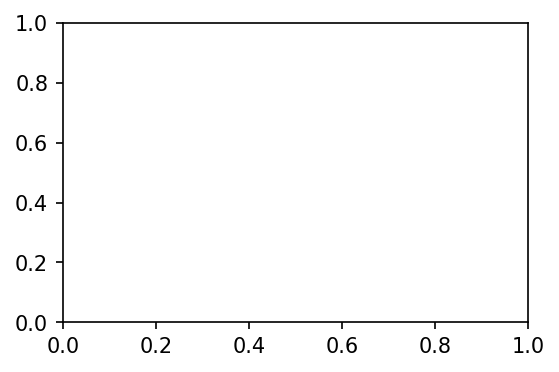

In [34]:
# temp = 2
mag_field = 0
# interactions = np.array([1.0, 0.5]) # p=1
interactions = np.array([1.0]) # p=1

# plots
fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
# fig1: Figure = pyplot.figure(figsize=(12*(4/9), 12), dpi=150)
# fig1: Figure = pyplot.figure(figsize=(4, 4*(2/3)), dpi=150)
    
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])
    
x_data = np.arange(0.001,2,0.001)
y_data = [corr_lenght_ising_original_limit_zero_h(x) for x in x_data]
          
ax.plot(x_data, y_data, marker="o", lw=0,color='C0',label='adjust without nv=1')
# ax.semilogy(x_data, y_data, marker="o", lw=0,color='C0',label='adjust without nv=1')

y_data = [correlation_lenght_limit(
    1/temp,
    mag_field,
    interactions
) for temp in x_data]

ax.plot(x_data, y_data, marker="x", lw=0,color='C1',label='adjust without nv=1')


# labels configurations
ax.xaxis.label.set_size(18)
ax.set_xlabel(r"$\beta J$")

ax.yaxis.label.set_size(18)
ax.set_ylabel(r"$\xi(T)$")

In [35]:
temp = 1
mag_field = 0
# interactions = np.array([1.0,0.5,0.3333]) # p=1
interactions = np.array([1.0]) # p=1
num_neighbors = len(interactions)
num_neighbors = len(interactions)
nnz_elems, nnz_rows, nnz_cols = _csr_log_transfer_matrix_parts_fast(
    temp, mag_field, interactions, num_neighbors
)

# Normalize nonzero matrix elements.
max_w_log_elem = np.max(nnz_elems)
nnz_elems -= max_w_log_elem
norm_nnz_elems = np.exp(nnz_elems)
# Construct the sparse matrix.
num_rows = 2 ** num_neighbors
w_shape = (num_rows, num_rows)
w_matrix = csr_matrix(
    (norm_nnz_elems, (nnz_rows, nnz_cols)), shape=w_shape
)
# Evaluate the largest eigenvalue, since it defines the free energy in
# the thermodynamic limit.
# noinspection PyTypeChecker
if num_tm_eigvals is None:
    num_eigvals = min(num_neighbors ** 2, num_rows - 2)
else:
    num_eigvals = min(num_tm_eigvals, num_rows - 2)
# For three or two interactions we take all eigenvalues
if len(interactions) <= 3:
    w_matrix_dense = w_matrix.todense()
    # w_all_norm_eigvals, w_all_norm_eigvect = scipy.linalg.eig(w_matrix_dense)
    # w_norm_eigvals = w_all_norm_eigvals[0]
    w_norm_eigvals, w_norm_eigvect = scipy.linalg.eig(w_matrix_dense)
else:
    w_norm_eigvals, w_norm_eigvect = sparse_eigs(
        w_matrix, k=num_eigvals, which="LM", return_eigenvectors=False
    )
print("eigvals: {}".format(w_norm_eigvals))
eigvals_norms: np.ndarray = np.abs(w_norm_eigvals)
eigvals_norms[::-1].sort()
#     max_eigval_norm_idx = eigvals_norms.argmax()
#     max_eigval_norm = eigvals_norms[max_eigval_norm_idx]
#     max_eigvect_norm = w_norm_eigvect[max_eigval_norm_idx]
#     reduced_eigvals = (w_norm_eigvals / max_eigval_norm)**r
print(eigvals_norms)
# print("Correlation lenght with matrix calculous: {}".format(math.log(eigvals_norms[0]/eigvals_norms[1])))
print("Correlation lenght with matrix calculous: {}".format(correlation_lenght_limit(temp,mag_field,interactions)))
print("Correlation lenght ising formula: {}".format(corr_lenght_ising_original_limit(T=temp,h=mag_field)))
print("Correlation lenght ising formula 2: {}".format(math.log(1/math.tanh(1/temp))))

NameError: name 'num_tm_eigvals' is not defined

In [74]:
# arr = np.array([1,4,3,5])
# arr.sort()
# print(arr)
help(arr.sort)

Help on built-in function sort:

sort(...) method of numpy.ndarray instance
    a.sort(axis=-1, kind=None, order=None)
    
    Sort an array in-place. Refer to `numpy.sort` for full documentation.
    
    Parameters
    ----------
    axis : int, optional
        Axis along which to sort. Default is -1, which means sort along the
        last axis.
    kind : {'quicksort', 'mergesort', 'heapsort', 'stable'}, optional
        Sorting algorithm. The default is 'quicksort'. Note that both 'stable'
        and 'mergesort' use timsort under the covers and, in general, the
        actual implementation will vary with datatype. The 'mergesort' option
        is retained for backwards compatibility.
    
        .. versionchanged:: 1.15.0
           The 'stable' option was added.
    
    order : str or list of str, optional
        When `a` is an array with fields defined, this argument specifies
        which fields to compare first, second, etc.  A single field can
        be specified as

In [55]:
temp = 2
mag_field = 0
# interactions = np.array([1.0,0.5,0.3333]) # p=1
interactions = np.array([1.0,0.5]) # p=1
num_neighbors = len(interactions)
r=10000
num_tm_eigvals = None

num_neighbors = len(interactions)
nnz_elems, nnz_rows, nnz_cols = _csr_log_transfer_matrix_parts_fast(
    temp, mag_field, interactions, num_neighbors
)

# Normalize nonzero matrix elements.
max_w_log_elem = np.max(nnz_elems)
nnz_elems -= max_w_log_elem
norm_nnz_elems = np.exp(nnz_elems)
# Construct the sparse matrix.
num_rows = 2 ** num_neighbors
w_shape = (num_rows, num_rows)
w_matrix = csr_matrix(
    (norm_nnz_elems, (nnz_rows, nnz_cols)), shape=w_shape
)
# Evaluate the largest eigenvalue, since it defines the free energy in
# the thermodynamic limit.
# noinspection PyTypeChecker
if num_tm_eigvals is None:
    num_eigvals = min(num_neighbors ** 2, num_rows - 2)
else:
    num_eigvals = min(num_tm_eigvals, num_rows - 2)
# For three or two interactions we take all eigenvalues
if len(interactions) <= 3:
    w_matrix_dense = w_matrix.todense()
    # w_all_norm_eigvals, w_all_norm_eigvect = scipy.linalg.eig(w_matrix_dense)
    # w_norm_eigvals = w_all_norm_eigvals[0]
    w_norm_eigvals, w_norm_eigvect = scipy.linalg.eig(w_matrix_dense)
else:
    w_norm_eigvals, w_norm_eigvect = sparse_eigs(
        w_matrix, k=num_eigvals, which="LM", return_eigenvectors=False
    )
eigvals_norms: np.ndarray = np.abs(w_norm_eigvals)
print('eigenval: {}'.format(w_norm_eigvals))
max_eigval_norm_idx = eigvals_norms.argmax()
max_eigval_norm = eigvals_norms[max_eigval_norm_idx]
max_eigvect_norm = w_norm_eigvect[max_eigval_norm_idx]
reduced_eigvals = (eigvals_norms / max_eigval_norm)
print('reduced eigenval: {}'.format(reduced_eigvals))
reduced_eigvals = (eigvals_norms / max_eigval_norm)**r
print('reduced eigenval: {}'.format(reduced_eigvals))
sigma_z = z_projection_gen(num_neighbors-1)# matrix extension
corr_function = 0
for ind_eig in range(len(reduced_eigvals)):
    if ind_eig == max_eigval_norm_idx:
        pass
    else:
        corr_function += (reduced_eigvals[ind_eig])*(
            np.abs(max_eigvect_norm.dot(sigma_z.dot(w_norm_eigvect[ind_eig])))**2
        )
corr_function

eigenval: [ 1.16894424+0.j  0.89263487+0.j -0.26051431+0.j  0.1989352 +0.j]
reduced eigenval: [1.         0.76362485 0.22286291 0.17018365]
reduced eigenval: [1. 0. 0. 0.]


0.0

In [53]:
0.99932909**100000

7.128042888195157e-30

In [9]:
print(np.abs(w_norm_eigvect[1].dot(sigma_z.dot(max_eigvect_norm)))**2)
np.abs(max_eigvect_norm.dot(sigma_z.dot(w_norm_eigvect[1])))**2

1.0


1.0

C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, '$\\mathcal{G}(\\rho)$')

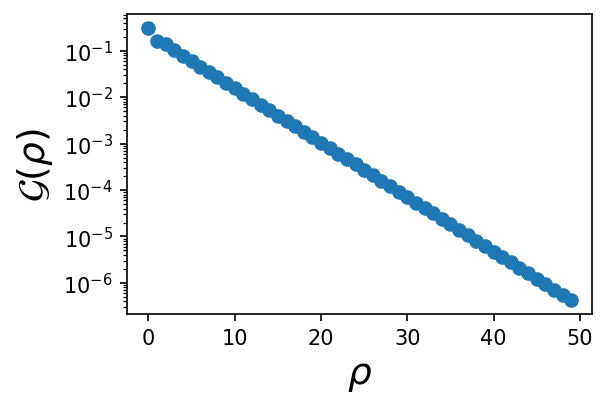

In [39]:
temp = 2
mag_field = 0
interactions = np.array([1.0, 0.5]) # p=1
# interactions = np.array([1.0]) # p=1
num_neighbors = len(interactions)
num_tm_eigvals = None

# plots
fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
# fig1: Figure = pyplot.figure(figsize=(12*(4/9), 12), dpi=150)
# fig1: Figure = pyplot.figure(figsize=(4, 4*(2/3)), dpi=150)
    
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])
    
x_data = np.arange(0,50,1)
y_data = [correlation_function_TL(
    x,
    temp,
    mag_field,
    interactions
) for x in x_data]
          
# ax.plot(x_data, y_data, marker="o", lw=0,color='C0',label='adjust without nv=1')
ax.semilogy(x_data, y_data, marker="o", lw=0,color='C0',label='adjust without nv=1')

# labels configurations
ax.xaxis.label.set_size(18)
ax.set_xlabel(r"$\rho$")

ax.yaxis.label.set_size(18)
ax.set_ylabel(r"$\mathcal{G}(\rho)$")

# print(correlation_lenght_limit(
#     temp,
#     mag_field,
#     interactions))

C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\lib\site-packages\ipykernel_launcher.py:70: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0, 0.5, '$\\xi(\\rho)$')

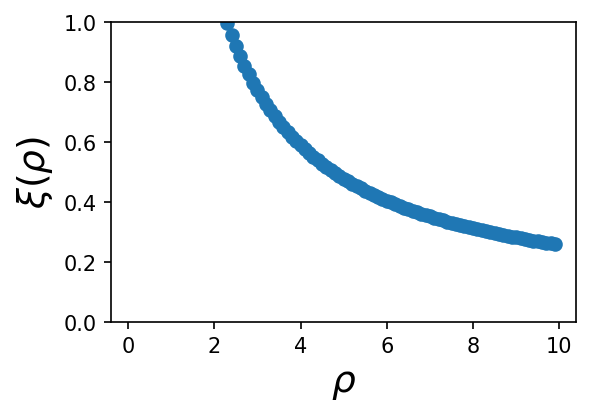

In [17]:
# plots
fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
# fig1: Figure = pyplot.figure(figsize=(12*(4/9), 12), dpi=150)
# fig1: Figure = pyplot.figure(figsize=(4, 4*(2/3)), dpi=150)
    
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])
    
x_data = np.arange(0,10,0.1)
y_data = [correlation_lenght_TL(
    x,
    temp,
    mag_field,
    interactions
) for x in x_data]
          
ax.plot(x_data, y_data, marker="o", lw=0,color='C0',label='adjust without nv=1')

# labels configurations
ax.xaxis.label.set_size(18)
ax.set_xlabel(r"$\rho$")
ax.set_ylim([0,1])

ax.yaxis.label.set_size(18)
ax.set_ylabel(r"$\xi(\rho)$")

### Perfect Ising case
The formula for the correlation function of the perfect Ising chain is 
$$
\mathcal{G}(\rho) = \left(\frac{\cosh(\beta h) - \sqrt{\sinh^2(\beta h) + e^{-4\beta J}}}{\cosh(\beta h) + \sqrt{\sinh^2(\beta h) + e^{-4\beta J}}}\right)^\rho \frac{e^{-4\beta J}}{\sinh^2(\beta h) + e^{-4\beta J}}
$$
normalization $T=k_BT/J$, and $h=h/J$ 

In [3]:
def correlation_function_perfect_ising_TL(
    r: int,
    T: float,
    h: float
):
    return ( 
        ( (math.cosh(h/T) - math.sqrt(math.sinh(h/T)**2 + math.exp(-4/T)) )
            /(math.cosh(h/T) + math.sqrt(math.sinh(h/T)**2 + math.exp(-4/T))) )**r
        )* ((math.exp(-4/T))/(math.sinh(h/T)**2+math.exp(-4/T)))

C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, '$\\mathcal{G}(\\rho)$')

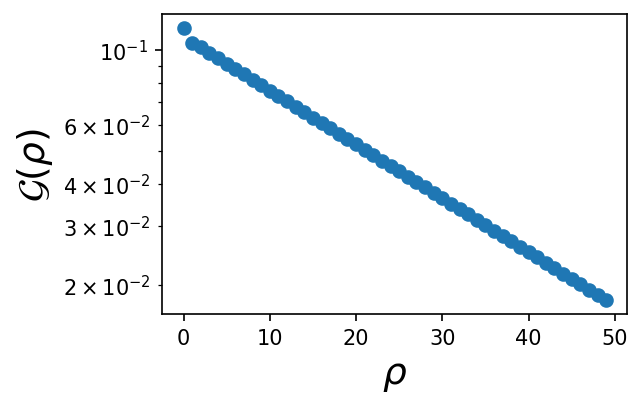

In [8]:
temp = 1
mag_field = 0
interactions = np.array([1.0,0.5]) # p=1
# plots
fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
# fig1: Figure = pyplot.figure(figsize=(12*(4/9), 12), dpi=150)
# fig1: Figure = pyplot.figure(figsize=(4, 4*(2/3)), dpi=150)
    
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

x_data = np.arange(0,50,1)
y_data = [correlation_function_TL(
    x,
    temp,
    mag_field,
    interactions
) for x in x_data]
          
# ax.plot(x_data, y_data, marker="x", lw=0,color='C0',label='adjust without nv=1')
ax.semilogy(x_data, y_data, marker="o", lw=0,color='C0',label='adjust without nv=1')

x_data = np.arange(0,50,1)
y_data = [correlation_function_perfect_ising_TL(
    x,
    temp,
    mag_field,
) for x in x_data]
          
# ax.plot(x_data, y_data, marker="o", lw=0,color='C1',label='adjust without nv=1')

# labels configurations
ax.xaxis.label.set_size(18)
ax.set_xlabel(r"$\rho$")

ax.yaxis.label.set_size(18)
ax.set_ylabel(r"$\mathcal{G}(\rho)$")